Импорт необходимых для работы библиотек

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Загрузим данные и проведем их первичный анализ

`TRAIN.CSV:`

Это основная таблица, которая связывает студента с вопросом или лекцией, с которыми он взаимодействует, а также дополнительная информация
об этом взаимодействии. Список колонок и краткое их описание:

* row_id: (int64) порядковый номер строки в этой таблице.
* timestamp: (int64) время в миллисекундах между текущим взаимодействием и первым событием связанным с данным ученика.
* user_id: (int32) идентификационный код ученика.
* content_id: (int16) идентификационный код вопроса или лекции.
* content_type_id: (int8) 0 если это вопрос, 1 если лекция.
* task_container_id: (int16) идентификационный код группы вопросов, в которой задан текущий вопрос.
* user_answer: (int8) вариант ответа, который выбрал ученик. Всего вариантов может быть 4. В случае если взаимодействие - это лекция, а не вопрос, то данное поле равно -1.
* answered_correctly: (int8) правильно ли ученик ответил на вопрос. В случае, если взаимодействие - это лекция, а не вопрос, то данное поле равно -1. Данное поле нужно будет предсказывать.
* prior_question_elapsed_time: (float32) среднее время в миллисекундах, которое ученику потребовалось, чтобы ответить на все вопросы в предыдущей группе, игнорируя любые лекции между ними. Равен 0 для первой группы вопросов, заданной ученику.
* prior_question_had_explanation: (bool) смотрел ли ученик объяснение и правильный ответ на предыдущий вопрос.



In [59]:
ds_train_prev = pd.read_csv('data/train.csv')

In [60]:
ds_train_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


In [61]:
ds_train_prev.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


Объем использумой памяти можно сократить, преобразовав типы данных. Загрузим данные, преобразовав типы данных

In [62]:
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

In [63]:
ds_train = pd.read_csv('data/train.csv', dtype=dtypes)
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 3.2 GB


Преобразование данных позволило уменьшить размер данных более чем в 2 раза (с +7.5 Гб до 3.2 Гб)

In [64]:
ds_train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


Проверим столбцы на наличие пропусков

In [65]:
ds_train.isna().mean()

row_id                            0.000000
timestamp                         0.000000
user_id                           0.000000
content_id                        0.000000
content_type_id                   0.000000
task_container_id                 0.000000
user_answer                       0.000000
answered_correctly                0.000000
prior_question_elapsed_time       0.023230
prior_question_had_explanation    0.003877
dtype: float64

Видим, что пропуски присутствуют в столбцах:
* prior_question_elapsed_time - 2.3 %
* prior_question_had_explanation - 0.4 % 

При поиске зависимостей от этих параметров, нужно иметь в виду наличие пропущенных значений

In [66]:
ds_train.describe()

,row_id,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,9.887879e+07
mean,5.061517e+07,7.703644e+09,1.076732e+09,5.219605e+03,9.040624e+02,1.376123e+00,6.251644e-01,2.542384e+04
std,2.922268e+07,1.159266e+10,6.197163e+08,3.866359e+03,1.358302e+03,1.192896e+00,5.225307e-01,1.994815e+04
min,0.000000e+00,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,2.530758e+07,5.243436e+08,5.408116e+08,2.063000e+03,1.040000e+02,0.000000e+00,0.000000e+00,1.600000e+04
50%,5.061517e+07,2.674234e+09,1.071781e+09,5.026000e+03,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04
75%,7.592275e+07,9.924551e+09,1.615742e+09,7.425000e+03,1.094000e+03,3.000000e+00,1.000000e+00,2.966600e+04
max,1.012303e+08,8.742577e+10,2.147483e+09,3.273600e+04,9.999000e+03,3.000000e+00,1.000000e+00,3.000000e+05


`QUESTIONS.CSV:`

Таблица описывающая вопрос. Количество вопросов в отличии от количества учеников заранее зафиксировано, также задания повторно предлагаются
различным ученикам. Список колонок:

* question_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* bundle_id: код по которому вопросы объединяются в группы.
* correct_answer: правильный ответ на вопрос.
* part: один из семи типов вопросов TOEIC
* tags: один или несколько кодов с тэгами для данного вопроса. Описание тэгов не представлено, но самих кодов достаточно для того, чтобы
сделать кластеризацию.

In [67]:
ds_question_prev = pd.read_csv('data/questions.csv')
ds_question_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [68]:
ds_question_prev.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


Объем использумой памяти можно сократить, преобразовав типы данных. Загрузим данные, преобразовав типы данных

In [69]:
dtypes = {
    "question_id": "int16",
    "bundle_id": "int16",
    "correct_answer": "int16",
    "part": "int8",
    "tags": "object"
}

In [70]:
ds_question = pd.read_csv('data/questions.csv', dtype=dtypes)

In [71]:
ds_question.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int16 
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
dtypes: int16(3), int8(1), object(1)
memory usage: 198.2+ KB


In [72]:
ds_question.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [73]:
ds_question.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


In [74]:
ds_question.isna().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

Видим, что есть один пропуск в столбце tags.

`LECTURES.CSV: METADATA FOR THE LECTURES WATCHED BY USERS AS THEY PROGRESS IN THEIR EDUCATION.`

* lecture_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* tag: один тэг в качестве числа, который представляет лекцию, его значение не дано, также как и в вопросах.
* part: один из семи типов, который был в таблице с вопросами.
* type_of: краткое описание основной цели лекции.



In [75]:
ds_lectures_prev = pd.read_csv('data/lectures.csv')

In [76]:
ds_lectures_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [77]:
ds_lectures_prev.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


Объем использумой памяти можно сократить, преобразовав типы данных. Загрузим данные, преобразовав типы данных

In [78]:
dtypes = {
    "lecture_id": "int16",
    "tag": "int16",
    "part": "int8",
    "type_of": "object"
}

In [79]:
ds_lectures = pd.read_csv('data/lectures.csv', dtype=dtypes)
ds_lectures.info()
ds_lectures.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int16 
 1   tag         418 non-null    int16 
 2   part        418 non-null    int8  
 3   type_of     418 non-null    object
dtypes: int16(2), int8(1), object(1)
memory usage: 5.4+ KB


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [80]:
ds_lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


In [81]:
ds_lectures.isna().sum()

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

Видим, что пропусков нет

## Проанализируем датасет с лекциями

### Распеределение количества лекций по различным частям

In [82]:
ds_lectures['part'].value_counts()

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

(array([ 54.,  56.,  19.,  31., 143.,  83.,  32.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <BarContainer object of 7 artists>)

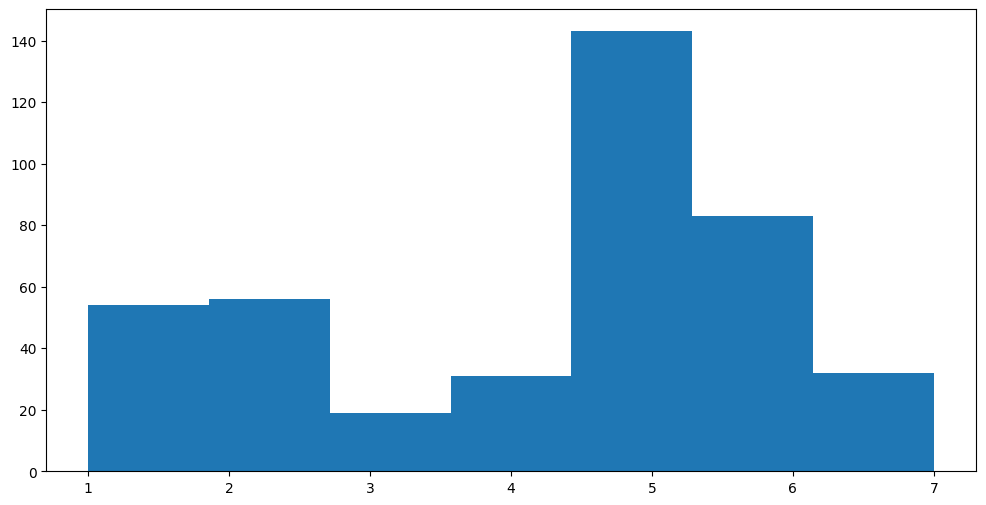

In [83]:
fig = plt.figure( figsize=( 12, 6))
plt.hist(ds_lectures['part'], bins=7)


Видим, что наибольшее количество лекций было в 5 части (143 лекции).

### Распеределение количества лекций по различным целям

In [84]:
ds_lectures['type_of'].value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

(array([222.,   0.,   0., 186.,   0.,   0.,   7.,   0.,   0.,   3.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

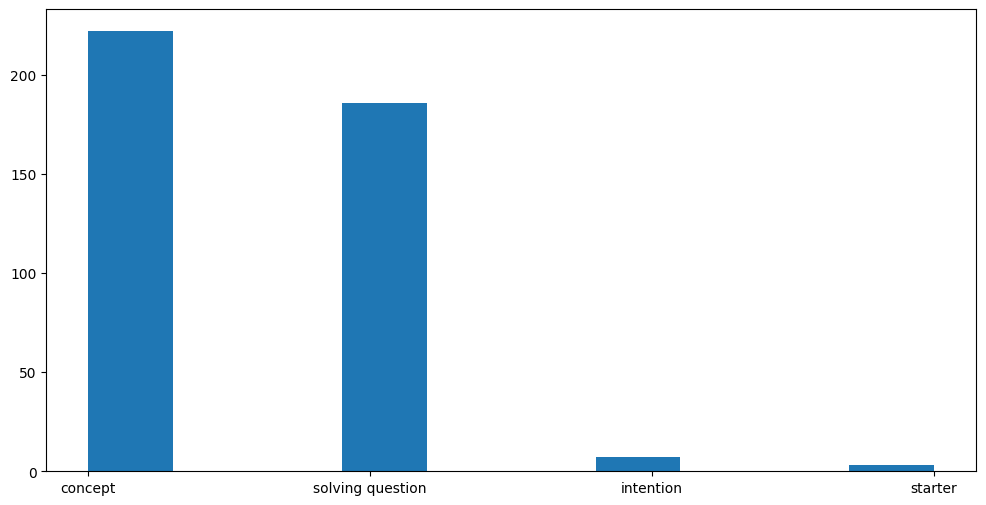

In [85]:
fig = plt.figure( figsize=( 12, 6))
plt.hist(ds_lectures['type_of'])


Видим, что наибольшее количество лекций, дающих общее представление (цель - concept) (222 лекции).

### Распеределение количества лекций по различным тэгам

In [86]:
ds_lectures['tag'].value_counts()

136    7
27     6
161    6
74     6
134    6
      ..
90     1
112    1
31     1
138    1
2      1
Name: tag, Length: 151, dtype: int64

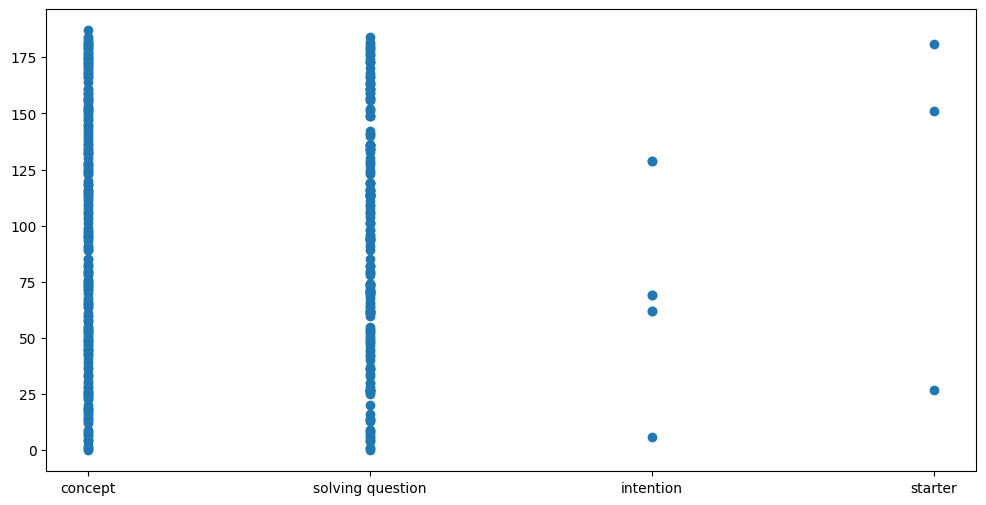

In [87]:
fig = plt.figure( figsize=( 12, 6))
plt.scatter(ds_lectures['type_of'], ds_lectures['tag'])

Наибольшее количество тэгов имеют лекции с теорией (concept) и с решением вопросов (solving question)

### Распеределение целей лекций для каждой из частей

In [88]:
ds_lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


<AxesSubplot: xlabel='part', ylabel='Count'>

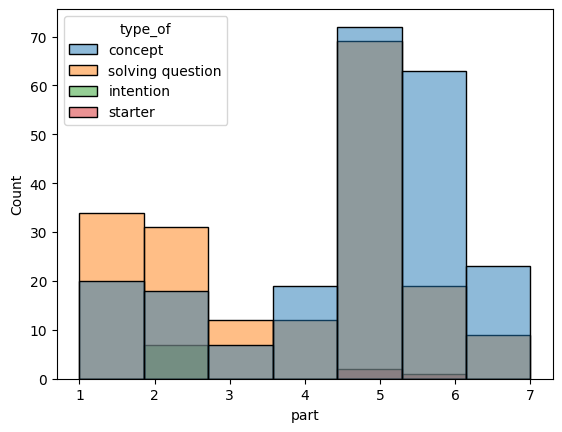

In [89]:
sns.histplot(data=ds_lectures, x='part', hue='type_of', bins=7)

Первые три части направлены на решение вопросов (solving question), остальные - на теоретический материал (concept)

## Проанализируем датасет с вопросами

`QUESTIONS.CSV:`

Таблица описывающая вопрос. Количество вопросов в отличии от количества учеников заранее зафиксировано, также задания повторно предлагаются
различным ученикам. Список колонок:

* question_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* bundle_id: код по которому вопросы объединяются в группы.
* correct_answer: правильный ответ на вопрос.
* part: один из семи типов вопросов TOEIC
* tags: один или несколько кодов с тэгами для данного вопроса. Описание тэгов не представлено, но самих кодов достаточно для того, чтобы
сделать кластеризацию.

In [90]:
ds_question['bundle_id'].describe()

count    13523.000000
mean      6760.510907
std       3903.857783
min          0.000000
25%       3379.500000
50%       6761.000000
75%      10140.000000
max      13522.000000
Name: bundle_id, dtype: float64

### Распределение вопросов по частям

In [91]:
ds_question['part'].value_counts()

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

(array([ 54.,  56.,   0.,  19.,   0.,  31., 143.,   0.,  83.,  32.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

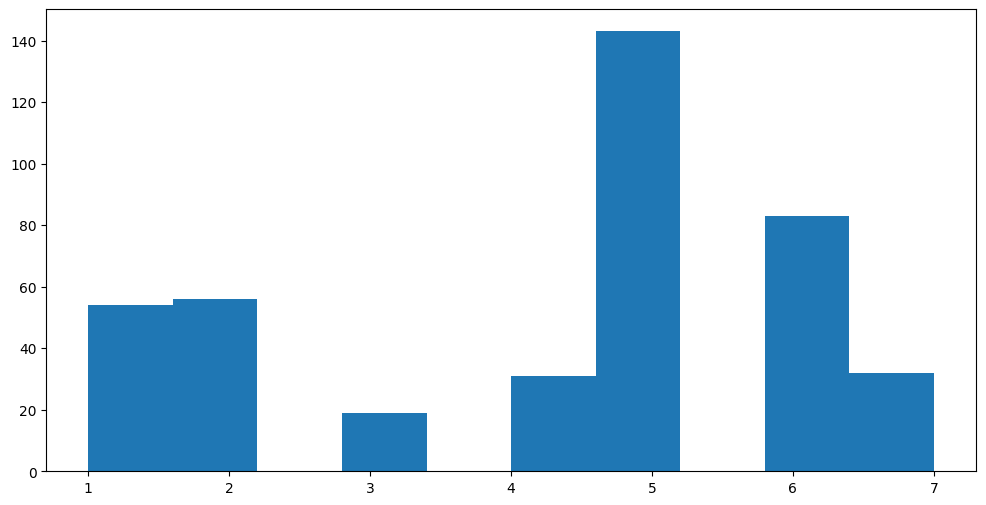

In [92]:
fig = plt.figure( figsize=( 12, 6))
plt.hist(ds_lectures['part'])

Наибольшее количество вопросов в 5 части (5511)

# 2. Найдем зависимости умпеваемости студентов от разных параметров

### 2.0 Общая информация

Выведем распределение правильных и неправильных ответов

In [93]:
answers = ds_train[ds_train['answered_correctly'] != -1]['answered_correctly'].value_counts()
answers

1    65244627
0    34026673
Name: answered_correctly, dtype: int64

Text(0, 0.5, 'answers')

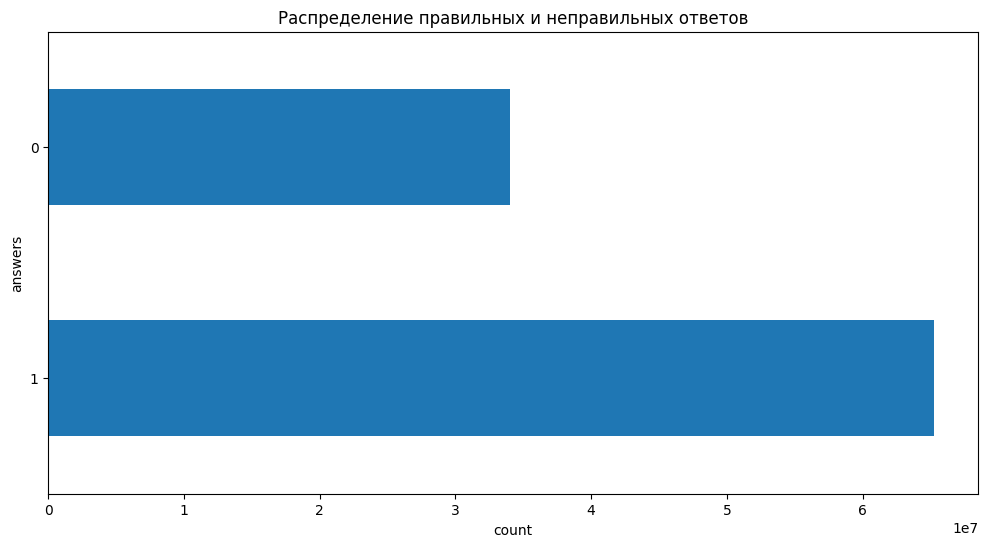

In [94]:
fig = plt.figure(figsize=(12, 6))
answers.plot.barh()
plt.title( "Распределение правильных и неправильных ответов")
plt.xlabel('count')
plt.ylabel('answers')

### 2.1 Зависимсоть от времени нахождения на курсе

Выведем распределение доли правильных ответов от времени нахождения на курсе (как давно студент зарегистрировался). <br>
Для этого разделим данные на пять временных групп, для каждой определим временные интервалы и долю правильных ответов, которые дали студенты

In [95]:
bin_labels_5 = [ 'Bin_1' , 'Bin_2' , 'Bin_3' , 'Bin_4' , 'Bin_5' ]
ds_train['ts_bin'] = pd.qcut(ds_train['timestamp'], q=5, labels=bin_labels_5)

cor = (ds_train['answered_correctly'] == 1) # правильные ответы
wrn = (ds_train['answered_correctly'] == 0) # неправильные ответы

ds_answers = ds_train[ds_train['answered_correctly'] != -1]['answered_correctly']

list_of_percent = list()
list_of_min_time = list()
list_of_max_time = list()

for bin_label in bin_labels_5:
    bin = (ds_train['ts_bin'] == bin_label)
    percent = round(ds_answers[bin][cor].count() / (ds_answers[bin][cor].count() + ds_answers[bin][wrn].count()),2)
    days = round(ds_train[bin]['timestamp'] / 86_400_000, 2) # 86_400_000 мс в сутках
    list_of_percent.append(percent)
    list_of_min_time.append(days.min()) # min порог временной группы 
    list_of_max_time.append(days.max()) # max порог временной группы

dict = {'ts_bin': bin_labels_5, 
        'percent': list_of_percent, 
        'min_time': list_of_min_time, 
        'max_time': list_of_max_time}
ds_depend_time = pd.DataFrame(dict)

ds_depend_time


,ts_bin,percent,min_time,max_time
0,Bin_1,0.59,0.00,3.37
1,Bin_2,0.67,3.37,18.34
2,Bin_3,0.68,18.34,50.24
3,Bin_4,0.68,50.24,152.43
4,Bin_5,0.68,152.43,1011.87


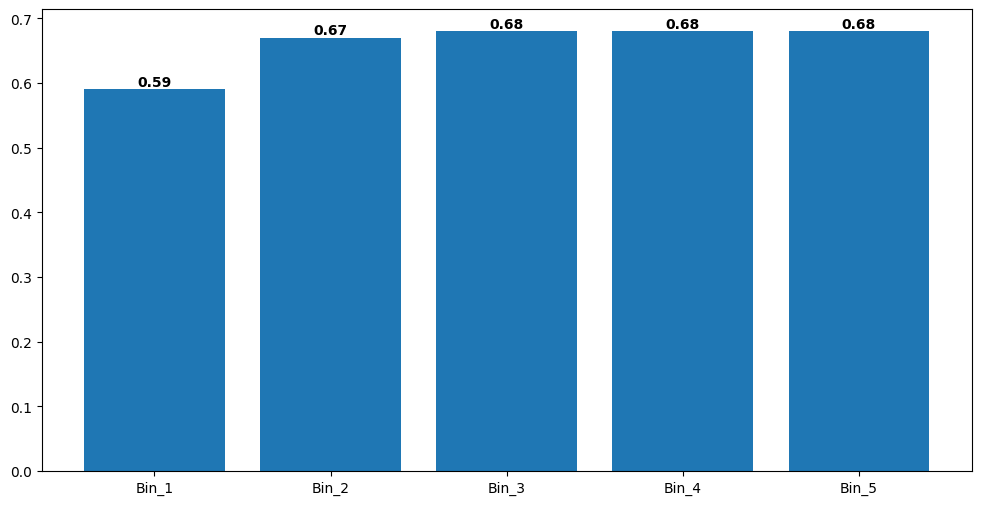

In [96]:
# отразим полученные результаты
fig = plt.figure(figsize=( 12, 6))
plt.bar(ds_depend_time.ts_bin, ds_depend_time.percent)
for bin, percent in zip(ds_depend_time.ts_bin, ds_depend_time.percent):
    plt.text(bin, percent, percent,  fontweight='bold',  va='bottom' , ha='center' )

`Доля правильных ответов не зависит существенно от времени нахождения на курсе.` <br>
Все временные группы имеют примерно одинаковые доли правильных ответов, за исключением первого временного интервала (самое малое время нахождения на курсе, не более 4,19 суток), для которого наблюдаются результаты ниже остальных 

In [97]:
ds_train[ds_train['ts_bin'] == 'Bin_1']['timestamp'].mode()

0    0
Name: timestamp, dtype: int64

При этом в первой временной группе наибольшее количество студентов имеют  timestamp = 0 (только зарегистрировались)

### 2.2 Зависимоcть от времени выполнения заданий

Создадим датасет для дальнейшего анализа:
* number_of_answers - всего отвеченных вопросов
* count_correct - правильно отвеченных вопросов
* share_of_cor - доля правильных ответов
* mean_time - среднее время выполнения одного задания

In [204]:
ds_answers = ds_train[ds_train['answered_correctly'] != -1] # ответы
answer = ds_answers[['user_id', 'prior_question_elapsed_time']].groupby(['user_id']).sum() # всего ответов по каждому студенту


cor = (ds_train['answered_correctly'] == 1) # правильные ответы
wrn = (ds_train['answered_correctly'] == 0) # неправильные ответы

answer['count_correct'] = ds_answers['user_id'][cor].value_counts()
answer['number_of_answer'] = ds_answers['user_id'][cor].value_counts() + ds_answers['user_id'][wrn].value_counts()

# доля правильных ответов
answer['share_of_cor'] = round(answer['count_correct'] / answer['number_of_answer'],2)

# среднее время выполнения одного задания 
answer['mean_time'] = round(answer['prior_question_elapsed_time'] /answer['number_of_answer'], 2)


answer

,prior_question_elapsed_time,count_correct,number_of_answer,share_of_cor,mean_time
user_id,,,,,
115,896999.0,32.0,46.0,0.70,19499.98
124,544997.0,7.0,30.0,0.23,18166.57
2746,325000.0,11.0,19.0,0.58,17105.26
5382,4470000.0,84.0,125.0,0.67,35760.00
8623,2819600.0,70.0,109.0,0.64,25867.89
...,...,...,...,...,...
2147470770,5212661.0,173.0,226.0,0.77,23064.87
2147470777,15041106.0,520.0,752.0,0.69,20001.47
2147481750,879000.0,38.0,50.0,0.76,17580.00


In [231]:
answer.describe()

,prior_question_elapsed_time,count_correct,number_of_answer,share_of_cor,mean_time
count,3.932590e+05,393259.000000,393259.000000,393259.000000,393259.000000
mean,6.392218e+06,165.898957,252.420466,0.545178,23270.320398
std,1.962574e+07,519.614732,735.052079,0.162766,7759.287135
min,0.000000e+00,1.000000,2.000000,0.030000,0.000000
25%,5.480000e+05,11.000000,30.000000,0.430000,18599.900000
50%,9.840000e+05,23.000000,40.000000,0.570000,22144.330000
75%,3.585000e+06,95.000000,155.000000,0.670000,26631.580000
max,1.042999e+09,14300.000000,17609.000000,0.990000,218514.290000


Узнаем среднее время выполнения задания для студентов, c разной долей правильных ответов

In [233]:
# удалим значения inf
answer = answer.replace([np.inf, -np.inf], np.nan)
answer.dropna(inplace=True)


answer['mean_share_of_cor'] = pd.qcut(answer['share_of_cor'], q=5)
ds = round(answer[['mean_time', 'mean_share_of_cor']].groupby(['mean_share_of_cor']).mean())

ds

,mean_time
mean_share_of_cor,
"(0.028999999999999998, 0.4]",22079.0
"(0.4, 0.52]",24442.0
"(0.52, 0.61]",23972.0
"(0.61, 0.69]",23345.0
"(0.69, 0.99]",22547.0


<AxesSubplot: xlabel='mean_share_of_cor'>

<Figure size 1200x600 with 0 Axes>

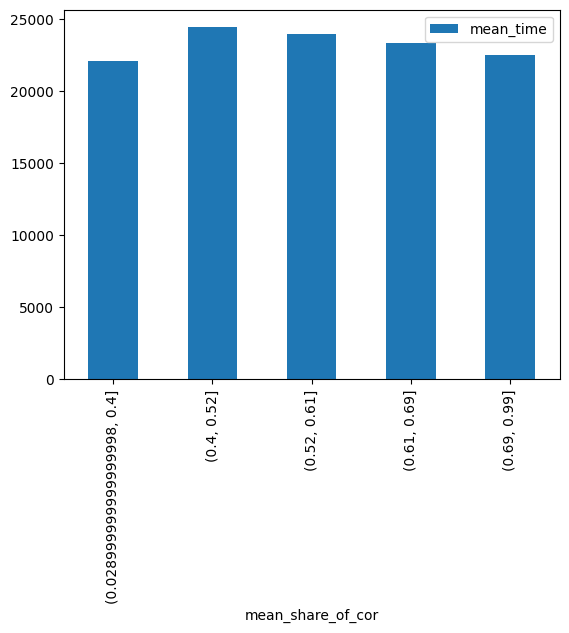

In [207]:
# отразим полученные результаты
fig = plt.figure(figsize=(12, 6))
ds.plot.bar()

`Среднее время выполнения задания не существенно влияет на долю правильных ответов` <br>
Наихудшие результаты при выполнении задания менее, чем за 17000 мс

### 2.3 Зависимсоть от количества выполненых заданий

In [209]:
answer.describe()

,prior_question_elapsed_time,count_correct,number_of_answer,share_of_cor,mean_time
count,3.932590e+05,393259.000000,393259.000000,393259.000000,393259.000000
mean,6.392218e+06,165.898957,252.420466,0.545178,23270.320398
std,1.962574e+07,519.614732,735.052079,0.162766,7759.287135
min,0.000000e+00,1.000000,2.000000,0.030000,0.000000
25%,5.480000e+05,11.000000,30.000000,0.430000,18599.900000
50%,9.840000e+05,23.000000,40.000000,0.570000,22144.330000
75%,3.585000e+06,95.000000,155.000000,0.670000,26631.580000
max,1.042999e+09,14300.000000,17609.000000,0.990000,218514.290000


Найдем медианное значения числа выполненных заданий

In [212]:
answer['count_correct'].median()

23.0

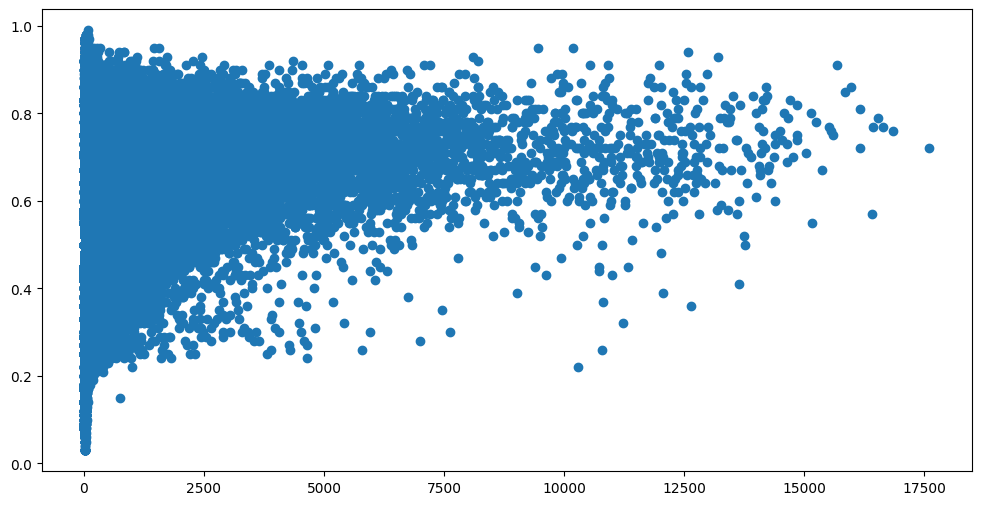

In [214]:
# отразим полученные результаты
fig = plt.figure(figsize=(12, 6))
plt.scatter(answer.number_of_answer, answer.share_of_cor)

Посмотрим детально долю правильных ответов студентов при разном количестве выполняемых заданий

* Анализ всех студентов

In [215]:
answer['share_of_cor'].median()

0.57

(array([ 1502., 11779., 29573., 44525., 58841., 85132., 98923., 49914.,
        11702.,  1368.]),
 array([0.03 , 0.126, 0.222, 0.318, 0.414, 0.51 , 0.606, 0.702, 0.798,
        0.894, 0.99 ]),
 <BarContainer object of 10 artists>)

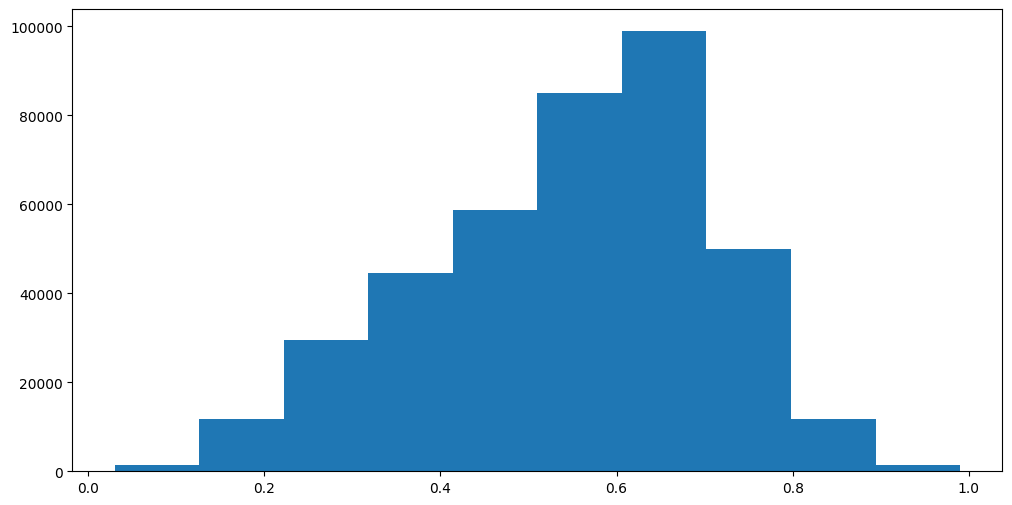

In [216]:
fig = plt.figure(figsize=( 12, 6))
plt.hist(answer['share_of_cor'])

* Анализ студентов, ответивших меньше, чем на 25 % вопросов

In [218]:
# отберем таких студентов
mask = (answer['number_of_answer'] < answer['number_of_answer'].quantile(0.25))
user_25 = answer[mask]
user_25

,prior_question_elapsed_time,count_correct,number_of_answer,share_of_cor,mean_time,mean_share_of_cor
user_id,,,,,,
2746,325000.0,11.0,19.0,0.58,17105.26,"(0.52, 0.61]"
8701,342000.0,10.0,17.0,0.59,20117.65,"(0.52, 0.61]"
51285,460000.0,12.0,22.0,0.55,20909.09,"(0.52, 0.61]"
81002,280000.0,9.0,17.0,0.53,16470.59,"(0.52, 0.61]"
99521,520000.0,22.0,27.0,0.81,19259.26,"(0.69, 0.99]"
...,...,...,...,...,...,...
2147427638,276000.0,6.0,13.0,0.46,21230.77,"(0.4, 0.52]"
2147451179,317000.0,6.0,16.0,0.38,19812.50,"(0.028999999999999998, 0.4]"
2147452043,475000.0,12.0,21.0,0.57,22619.05,"(0.52, 0.61]"


In [219]:
user_25['share_of_cor'].median()

0.52

(array([  699.,  2826.,  8330., 14944., 20394., 20366., 15747.,  9232.,
         2867.,   769.]),
 array([0.04 , 0.133, 0.226, 0.319, 0.412, 0.505, 0.598, 0.691, 0.784,
        0.877, 0.97 ]),
 <BarContainer object of 10 artists>)

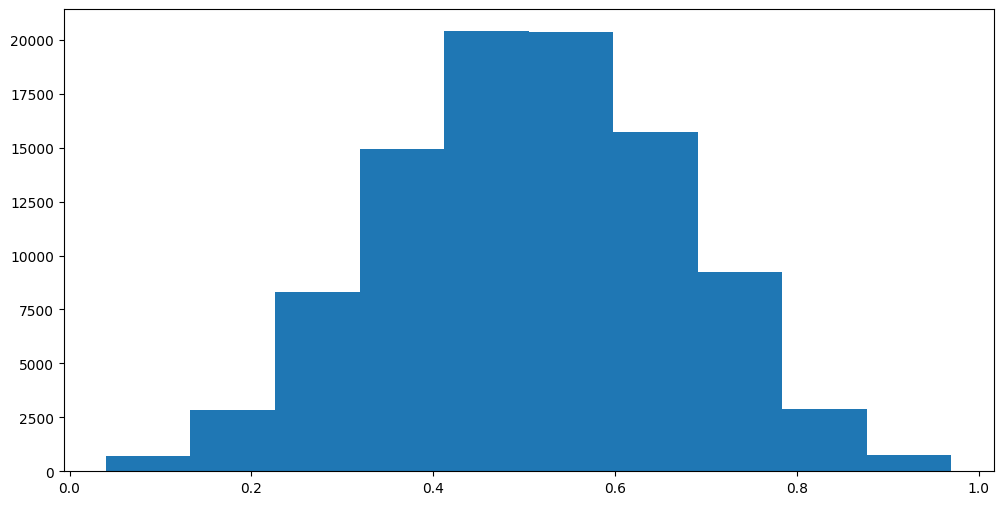

In [220]:
fig = plt.figure(figsize=( 12, 6))
plt.hist(user_25['share_of_cor'])

* Анализ студентов, которые ответили больше, чем на медианное количество вопросов (median)

In [222]:
# отберем таких студентов
answer
mask = (answer['number_of_answer'] > answer['number_of_answer'].median())
user_median = answer[mask]
user_median

,prior_question_elapsed_time,count_correct,number_of_answer,share_of_cor,mean_time,mean_share_of_cor
user_id,,,,,,
115,896999.0,32.0,46.0,0.70,19499.98,"(0.69, 0.99]"
5382,4470000.0,84.0,125.0,0.67,35760.00,"(0.61, 0.69]"
8623,2819600.0,70.0,109.0,0.64,25867.89,"(0.61, 0.69]"
12741,10516417.0,152.0,265.0,0.57,39684.59,"(0.52, 0.61]"
13134,26853840.0,878.0,1243.0,0.71,21604.05,"(0.69, 0.99]"
...,...,...,...,...,...,...
2147469944,5011872.0,200.0,273.0,0.73,18358.51,"(0.69, 0.99]"
2147470770,5212661.0,173.0,226.0,0.77,23064.87,"(0.69, 0.99]"
2147470777,15041106.0,520.0,752.0,0.69,20001.47,"(0.61, 0.69]"


In [223]:
user_median['share_of_cor'].median()

0.63

(array([5.2000e+01, 7.1600e+02, 3.9820e+03, 1.0535e+04, 2.4035e+04,
        5.4727e+04, 6.4337e+04, 3.2428e+04, 5.1690e+03, 3.5100e+02]),
 array([0.07 , 0.162, 0.254, 0.346, 0.438, 0.53 , 0.622, 0.714, 0.806,
        0.898, 0.99 ]),
 <BarContainer object of 10 artists>)

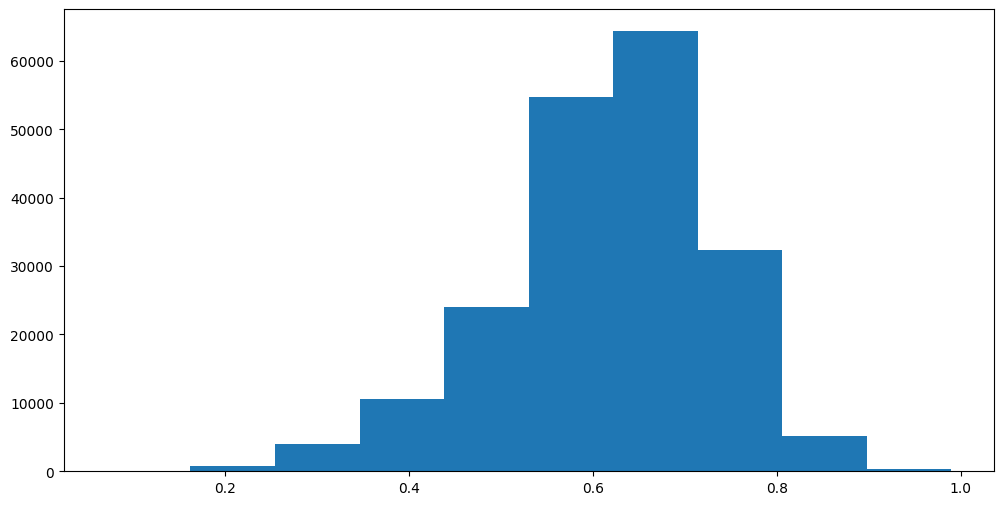

In [224]:
fig = plt.figure(figsize=( 12, 6))
plt.hist(user_median['share_of_cor'])

* Анализ студентов, ответивших на 75 % вопросов

In [227]:
mask = (answer['number_of_answer'] > answer['number_of_answer'].quantile(0.75))
top_users = answer[mask]
top_users.describe()

,prior_question_elapsed_time,count_correct,number_of_answer,share_of_cor,mean_time
count,9.800400e+04,98004.000000,98004.000000,98004.000000,98004.000000
mean,2.262493e+07,593.910493,881.049916,0.651211,25158.898115
std,3.453080e+07,915.431985,1280.096873,0.097308,7473.450242
min,1.599990e+05,36.000000,156.000000,0.150000,994.010000
25%,5.902000e+06,159.000000,251.000000,0.600000,20267.615000
50%,1.087643e+07,285.000000,442.000000,0.660000,23880.275000
75%,2.410870e+07,622.000000,938.000000,0.720000,28551.250000
max,1.042999e+09,14300.000000,17609.000000,0.950000,149745.750000


In [228]:
top_users['share_of_cor'].median()

0.66

(array([1.3000e+01, 2.8600e+02, 1.0660e+03, 3.0410e+03, 8.3710e+03,
        2.1019e+04, 3.4634e+04, 2.3770e+04, 5.3490e+03, 4.5500e+02]),
 array([0.15, 0.23, 0.31, 0.39, 0.47, 0.55, 0.63, 0.71, 0.79, 0.87, 0.95]),
 <BarContainer object of 10 artists>)

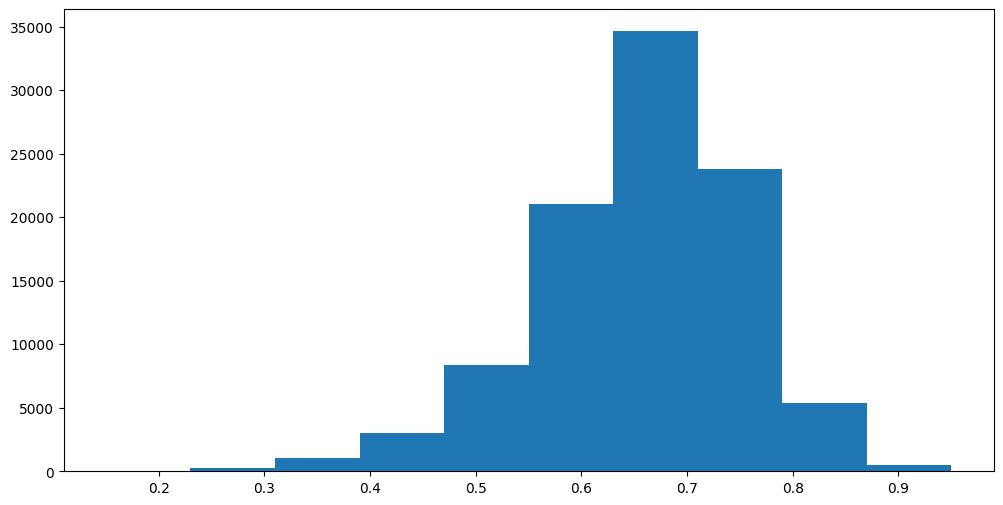

In [229]:
fig = plt.figure(figsize=( 12, 6))
plt.hist(top_users['share_of_cor'])

`Доля правильных ответов зависит от числа решаемых задач` <br>
При количестве решаемых задач (больше медианного) доля правильных ответов изеняется незначительно

### 2.4 Зависимоcть от использования объяснений

In [230]:
explanations = ds_train[ds_train['answered_correctly'] != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': 'mean'})
explanations


,answered_correctly
prior_question_had_explanation,
False,0.500629
True,0.673189
<NA>,0.680092


Text(0, 0.5, 'использование объяснений')

<Figure size 1200x600 with 0 Axes>

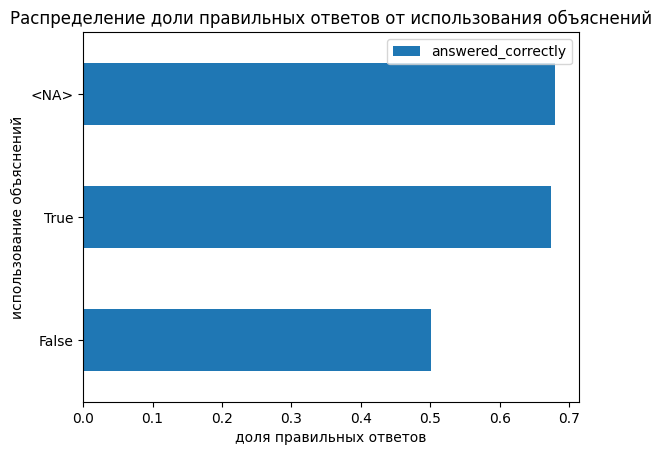

In [189]:
fig = plt.figure(figsize=(12, 6))
explanations.plot.barh()

plt.title( "Распределение доли правильных ответов от использования объяснений")
plt.xlabel('доля правильных ответов')
plt.ylabel('использование объяснений')

`Доля правильных ответов зависит от использования объяснений.` <br>
Студенты, использующие объяснения имеют более высокую долю правильных ответов